In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [3]:
# download the names.txt file from github
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2023-11-09 09:13:41--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.04s   

2023-11-09 09:13:41 (5.87 MB/s) - ‘names.txt’ saved [228145/228145]



In [4]:
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [77]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(vocab_size)
print(itos)

27
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [78]:
# shuffle up the words
import random
random.shuffle(words)

In [79]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182580, 8]) torch.Size([182580])
torch.Size([22767, 8]) torch.Size([22767])
torch.Size([22799, 8]) torch.Size([22799])


In [80]:
for x,y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> e
.......e --> b
......eb --> r
.....ebr --> i
....ebri --> m
...ebrim --> a
..ebrima --> .
........ --> h
.......h --> i
......hi --> l
.....hil --> t
....hilt --> o
...hilto --> n
..hilton --> .
........ --> j
.......j --> h
......jh --> e
.....jhe --> n
....jhen --> e
...jhene --> .


In [113]:
class Linear: #linear layer

  def __init__(self, fan_in, fan_out, bias=True): #fan_in: #inputs (features in)
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 #Random from Gaussian and Kaiming initialization
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x): #when you call the module
    self.x = x
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self): #return the tensors
    return [self.weight] + ([] if self.bias is None else [self.bias])

# ---------------------------------------------------------------------------------------------------

class BatchNorm1d: #BatchNorm layer (similar to Pytorch.nn.BatNorm1d)

  def __init__(self, dim, eps=1e-5, momentum=0.1): #momentum to keep track of the running stats
    self.eps = eps
    self.momentum = momentum
    self.training = True #some modules (like BatchNorm1d) behave differently whether we're training the neural net or running it in an evaluation mode or inference
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update': exponential moving average)
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta #variable used to track statistics (not present in Pytorch)
    # update the buffers
    if self.training:
      with torch.no_grad(): #Trained using exponential moving average
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

# ---------------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return [] #no params in this layer

# ---------------------------------------------------------------------------------------------------

class Embedding:
  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))

  def __call__(self,IX):
    self.out = self.weight[IX] #indexing operation in forward pass
    return self.out

  def parameters(self):
    return [self.weight]

# ---------------------------------------------------------------------------------------------------

class FlattenConsecutive: #flattening operation in forward pass (concatenation)

  def __init__(self,n):
    self.n = n

  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T//self.n, C*self.n) # T//n is integer division. n is the number of characters sampled (n-gram)
    # x.view(B,-1,C*n) With the -1, Python would infer the remaining dimension
    if x.shape[1] == 1:
      x = x.squeeze(1) #squeeze out the 1st dimension only, and return x.shape=[B,C*n]

    self.out = x
    return self.out

  def parameters(self):
    return []

# -------------------------------------------
class Sequential:

  def __init__(self, layers):
    self.layers = layers

  def __call__(self,x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out

  def parameters(self):
    # get parameters of all layers and stretch them out into one list
    return [p for layer in self.layers for p in layer.parameters()] #all params of the child modules

In [114]:
# original network
# n_embd = 10 # the dimensionality of the character embedding vectors
# n_hidden = 300 # the number of neurons in the hidden layer of the MLP
# model = Sequential([
#   Embedding(vocab_size, n_embd),
#   FlattenConsecutive(8), Linear(n_embd * 8, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(n_hidden, vocab_size),
# ])


n_embd = 24 # the dimensionality of the character embedding vectors
n_hidden = 128 # the number of neurons in the hidden layer of the MLP

#stack layers in a list
model = Sequential([
  Embedding(vocab_size, n_embd), #embedding table C
  FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size), #linear output layer

])

#parameter init
with torch.no_grad():
  model.layers[-1].weight *= 0.1 #last layer make less confidently wrong at initialization


parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

76579


In [115]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update: simple SGD (Stochastic Gradient Descent)
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

  #if i >= 1000:
    #break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.3124
  10000/ 200000: 2.2053
  20000/ 200000: 2.0419
  30000/ 200000: 2.2362
  40000/ 200000: 1.9706
  50000/ 200000: 2.2680
  60000/ 200000: 2.1200
  70000/ 200000: 1.8780
  80000/ 200000: 1.7187
  90000/ 200000: 1.6499
 100000/ 200000: 1.6985
 110000/ 200000: 2.0974
 120000/ 200000: 1.6694
 130000/ 200000: 1.7479
 140000/ 200000: 1.7336
 150000/ 200000: 1.8731
 160000/ 200000: 1.5749
 170000/ 200000: 1.5568
 180000/ 200000: 1.6010
 190000/ 200000: 1.8988


In [104]:
model.layers

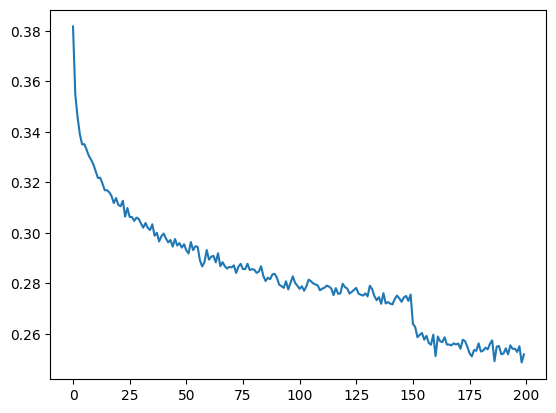

In [116]:
#plt.plot(lossi); #previous, less useful plot (we cannot extract conclusions because it oscillates too much depending on luck)
plt.plot(torch.tensor(lossi).view(-1,1000).mean(1)); #mean across the rows of a matrix of size 200x1000 containing the losses

In [117]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
  layer.training = False

In [118]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.7687808275222778
val 1.9925477504730225


In [119]:
# sample from the model

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all '...'
    while True:
      # forward pass the neural net
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break

    print(''.join(itos[i] for i in out)) # decode and print the generated word

athaliya.
taylan.
serger.
daevyn.
roselyn.
abdulmanna.
luqmar.
shirizna.
daisin.
prammonox.
axoma.
makaylah.
hanay.
solani.
rasiel.
ataiden.
dreson.
yaseus.
arshith.
may.


We have similar values for evaluation loss and training loss (train: 2.0582; eval: 2.1056). This means that we're not overfitting.

With the current implementation, we cannot make the network bigger in a productive way. Now, we are crushing all the input characters into a single layer at the beginning.

We can improve the architecture of our net by implementing a progressive feeding of information (data) to the neural network, just as WaveNet does. We want to make the network deeper, and at each level we will only fuse two consecutive elements: 2 characters, then 2 bigrams, then 2 4-grams, etc.

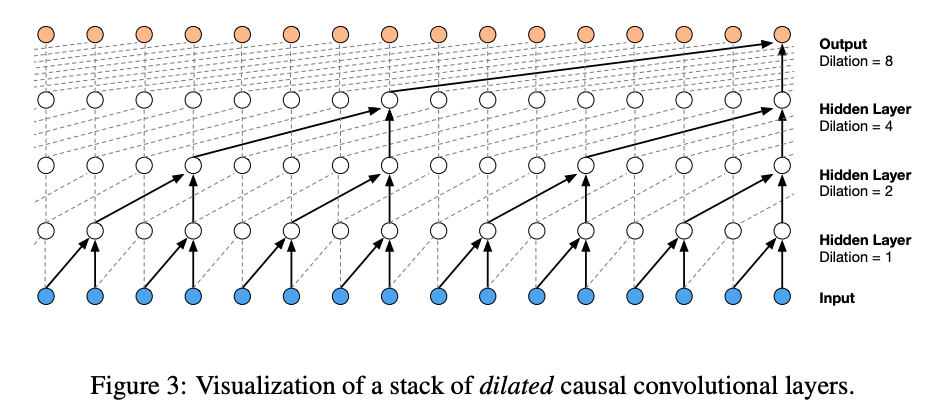

In [24]:
#Analyse the shapes of the in/out of every layers

#integers are translated into 10 dimensional vectors:
print(model.layers[0].out.shape) #output of embedding layer

#view the tensor differently (concatente):
print(model.layers[1].out.shape) #output of Flatten layer

#via matrix multiplication, the Linear layer increments the size of the matrix
print(model.layers[2].out.shape) #output of Linear layer

torch.Size([1, 8, 10])
torch.Size([1, 80])
torch.Size([1, 200])


In [110]:
for layer in model.layers:
  print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (32, 8, 10)
FlattenConsecutive : (32, 4, 20)
Linear : (32, 4, 68)
BatchNorm1d : (32, 4, 68)
Tanh : (32, 4, 68)
FlattenConsecutive : (32, 2, 136)
Linear : (32, 2, 68)
BatchNorm1d : (32, 2, 68)
Tanh : (32, 2, 68)
FlattenConsecutive : (32, 136)
Linear : (32, 68)
BatchNorm1d : (32, 68)
Tanh : (32, 68)
Linear : (32, 27)


Assuming a batch of 4 examples:

Output of embedding layer is [4, 8, 10]

Output of Flatten layer is [4, 80]

Output of Linear layer is [4, 200]

---


During the matrix multilication with the @ operator, it only works on the last dimension of the first term. The rest of dimensions remain unchanged.

The operation inside the linear layer (input @ weights + bias):

[4, 80] @ [80, 200] + [200] ---> would give a [4, 200] result

[4, 5, 2, 80] @ [80, 200] + [200] ---> would give a [4, 5, 2, 200] result.


This is useful to split the information in order to have a progressive feeding of the network.

---
Instead of having 8 samples:

1 2 3 4 5 6 7 8

We could group them as:

(1 2) (3 4) (5 6) (7 8)

This is like introducing a batch dimension to be processed in parallel.

If we divide in groups of 2, we would like 20 character to be fed into the first layer (2 10-dimensional examples), such that:

[4, 4, 20]

(4 (batch dimension; examples) by 4 groups (2nd batch dimension) of 20 characters)

We will need to change
- the output of the Flatten layer, so it outputs a [4,4,20]
- The input of the Linear layer, so it expects a 20 instead of 80



In [38]:
e = torch.randn(4, 8, 10) #goal: we want this to be (4,4,20) where consecutive 10-d vectors get concatenated
# e[:,::2,:] gives us the even characters [all, from beggining (0) to end skipping by 2, all]
# e[:, 1::2, :] gives us the odd characters [all, from 1 to end skipping by 2, all]
print(e[:,::2,:].shape)
print(e[:,1::2,:].shape)

torch.Size([4, 4, 10])
torch.Size([4, 4, 10])


In [40]:
explicit = torch.cat([e[:,::2,:], e[:, 1::2, :]], dim=2) #concatenate along the 2nd dimension
explicit.shape

torch.Size([4, 4, 20])

We don't need an explicit implementation of the concatenation, we can just call view and make the shape fit our interests:

In [41]:
(e.view(4,4,20) == explicit).all()

tensor(True)

In [37]:
#example of concatenating along different dimensions
ej = torch.randn(2,3)
print(ej)
print(torch.cat((ej,ej,ej), 0))
print(torch.cat((ej,ej,ej), 1))
print(torch.cat((ej,ej,ej), 0).shape)
print(torch.cat((ej,ej,ej), 1).shape)

tensor([[ 0.2561, -0.5088, -0.2295],
        [-1.6681, -2.2278, -0.8946]])
tensor([[ 0.2561, -0.5088, -0.2295],
        [-1.6681, -2.2278, -0.8946],
        [ 0.2561, -0.5088, -0.2295],
        [-1.6681, -2.2278, -0.8946],
        [ 0.2561, -0.5088, -0.2295],
        [-1.6681, -2.2278, -0.8946]])
tensor([[ 0.2561, -0.5088, -0.2295,  0.2561, -0.5088, -0.2295,  0.2561, -0.5088,
         -0.2295],
        [-1.6681, -2.2278, -0.8946, -1.6681, -2.2278, -0.8946, -1.6681, -2.2278,
         -0.8946]])
torch.Size([6, 3])
torch.Size([2, 9])
